In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from scipy import ndimage
from VMOSfunc import *
from scipy.stats import chisquare

/home/mainak/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/mainak/.local/lib/python2.7/site-packages/pyneb/utils/manage_atomic_data.py:528: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  gsconf = np.genfromtxt(execution_path('../atomic_data/levels/gsconfs.dat'), names=['atom', 'gsconf'], dtype=None)


In [2]:
def popt_central_fit(wo_wave,data,error,obj,p_init,z,broad2=False):
    k = 1+z
    select = (wo_wave>4750*k) & (wo_wave < 5090*k)
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1
    popt_full_fit,pcov_full_fit = leastsq(full_gauss,x0=p_init,args=(wo_wave[select],data[select],error[select]),maxfev = 10000000)
    Monte_Carlo_loops = 100
    parameters_MC = np.zeros((len(popt_full_fit),Monte_Carlo_loops))
    for l in range(Monte_Carlo_loops):
        iteration_data = np.random.normal(data[select],error[select]) 
        popt_MC,pcov_MC =leastsq(full_gauss,x0=popt_full_fit,args=(wo_wave[select],iteration_data,error[select]),maxfev = 10000000)
        parameters_MC[:,l]=popt_MC
    parameters_err = np.std(parameters_MC,1)  
    (amp_Hb_error,amp_OIII5007_error,vel_OIII_error,vel_sigma_OIII_error,amp_Hb_br_error,amp_OIII5007_br_error,vel_OIII_br_error,vel_sigma_OIII_br_error,amp_Hb1_error,amp_Fe5018_1_error,vel_Hb1_error,vel_sigma_Hb1_error,amp_Hb2_error,amp_Fe5018_2_error,vel_Hb2_error,vel_sigma_Hb2_error,m_error,c_error) = parameters_err
    return popt_full_fit,parameters_err 

def chi_squared(obj,z,wo_wave,data,error,popt_full_fit,broad2=False):
    (amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit) = popt_full_fit
    k = 1+z
    select = (wo_wave>4750*k) & (wo_wave < 5090*k)
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1

    fit = full_gauss(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
    residual = data[select] - fit
    ratio = residual/error[select]
    #chi_squared = np.sum(ratio**2)
    print ratio
    
def chi_squared(obj,z,wo_wave,data,error,popt_full_fit,broad2=False):
    (amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit) = popt_full_fit
    k = 1+z
    select = (wo_wave>4750*k) & (wo_wave < 5090*k)
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1

    fit = full_gauss(popt_full_fit,wo_wave[select],data[select],error[select])
    chi_squared = np.sum(fit**2)
    print chi_squared 

In [3]:
def plot(obj,wo_wave,data,error,z,popt_full_fit,broad2=False):
    (amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit) = popt_full_fit
    k = 1+z
    select = (wo_wave>4750*k) & (wo_wave < 5090*k)
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1

    fit = full_gauss(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
    residual = data[select] - fit
    fig = plt.gcf()
    fig.set_size_inches(7,5)
    #err = error[select]
    #SNR = residual/err
    #select1 = (wo_wave>5000) & (wo_wave < 5050)
   # print SNR[select1]
    
    fit = full_gauss(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
    residual = data[select] - fit
    plt.plot(wo_wave[select],data[select],'k-',label='data')
    plt.plot(wo_wave[select],fit,'r-',label='fit')
    plt.plot(wo_wave[select],residual,label='residual')
    plt.plot(wo_wave[select],Hb_O3_gauss(wo_wave[select],amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit) + continuum(wo_wave[select],m_fit,c_fit),'-g',label='core')
    plt.plot(wo_wave[select],Hb_O3_gauss(wo_wave[select],amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit) + continuum(wo_wave[select],m_fit,c_fit),color ='orange',label='wing')
    plt.plot(wo_wave[select],Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit) + continuum(wo_wave[select],m_fit,c_fit),color ='blue',label='BLR1')
    plt.plot(wo_wave[select],Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit) + continuum(wo_wave[select],m_fit,c_fit),'-c',label='BLR2')
    plt.title('%s_brightest_pixel_fit'%(obj))
    plt.xlabel(r"Wavelength ($\AA$)")
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$) ")
    plt.legend()
    plt.show()  
    plt.savefig('%s_central_spectrum.png'%(obj),overwrite=True)



In [4]:
def central_table(obj,popt_full_fit,brightest_pixel_x,brightest_pixel_y,parameters_err):
    central_coordinates = [int(brightest_pixel_x),int(brightest_pixel_y)]
    print central_coordinates
    popt = np.append(popt_full_fit,central_coordinates)
    central_cordinates_err = [0,0]
    err = np.append(parameters_err,central_cordinates_err)
    column_names={'amp_Hb':0,'amp_OIII5007':1,'vel_OIII':2,'vel_sigma_OIII':3,'amp_Hb_br':4,'amp_OIII5007_br':5,'vel_OIII_br':6,
              'vel_sigma_OIII_br':7,'amp_Hb1':8,'amp_Fe5018_1':9,'vel_Hb1':10,'vel_sigma_Hb1':11,'amp_Hb2':12,
              'amp_Fe5018_2':13,'vel_Hb2':14,'vel_sigma_Hb2':15,'m':16,'c':17,'central_x':18,'central_y':19}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[popt[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s_central_fit.fits'%(obj),overwrite=True)



In [7]:
def algorithm_script(obj,p_init,z,broad2,prefix_path_cube="/home/mainak/xdata/ftp.hidrive.strato.com/users/login-carsftp"):
    print '%s'%(obj)
    
    (wo_cube,wo_err,wo_wave,wo_header) = loadCube('%s/VMOS/%s/%s_blue.rscube.fits'%(prefix_path_cube,obj,obj))
    
    [brightest_pixel_x,brightest_pixel_y] = brightest_pixel(wo_cube)
    
    (data,error) = (wo_cube[:,brightest_pixel_y,brightest_pixel_x],wo_err[:,brightest_pixel_y,brightest_pixel_x])
    
    (popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,obj,p_init,z,broad2)
    
    print popt_full_fit,parameters_err
    
    redshift_vel = 300000.*z
    
    (amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit) = popt_full_fit

    (vel_OIII_rad,vel_OIII_br_rad) = (vel_OIII_fit - redshift_vel,vel_OIII_br_fit - redshift_vel)
    
    print vel_OIII_rad,vel_OIII_br_rad
    
    plot(obj,wo_wave,data,error,z,popt_full_fit,broad2)
    
    central_table(obj,popt_full_fit,brightest_pixel_x,brightest_pixel_y,parameters_err)
    
    chi_squared(obj,z,wo_wave,data,error,popt_full_fit,broad2)

HE1310-1051
[ 5.64331521e-01  8.98801261e+00  1.02905172e+04  9.19457233e+01
  4.22633058e-01  2.38450313e+00  1.02676121e+04  2.14010193e+02
  1.23916143e+00  1.46501246e-01  1.03836268e+04  1.53461078e+03
  0.00000000e+00  0.00000000e+00  1.02810000e+04  1.50000000e+03
 -4.28927605e-01  3.23180679e+00] [2.07793089e-02 9.83647999e-02 2.23769868e-01 1.00325249e+00
 1.85591620e-02 1.07501508e-01 1.43503415e+00 3.05619654e+00
 3.05896234e-03 2.01790055e-03 2.81522179e+00 3.71641968e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.11230089e-03 2.60424060e-02]
9.51724451982227 -13.387892254193503


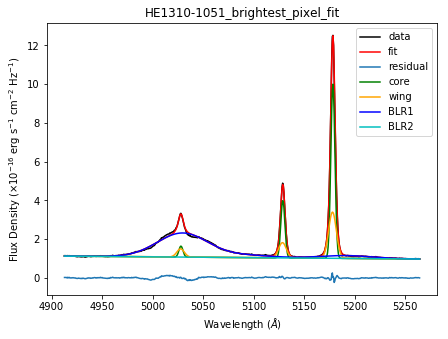

[18, 22]
4938.278448538144


In [8]:
z = {"HE1310-1051":0.03427}

objs = z.keys()

broad2= {'HE1310-1051':False}

p_init= {'HE1310-1051':[1.139,1.5,10281.0,100.0,0.0,0.0,10281.0,200.0,1.0,1.0,10281.0,1000.0,0.0,0.0,10281.0,1500.0,-0.001,2.0]}

for obj in objs:
     algorithm_script(obj,p_init[obj],z[obj],broad2[obj]) 


HE1338-1423
[ 1.07036954e+00  1.16381708e+01  1.23955289e+04  1.07827131e+02
  7.08809939e-01  4.07136080e+00  1.24197029e+04  2.85853618e+02
  3.95996467e+00  3.71635188e-01  1.24578993e+04  5.93031972e+02
  2.55793107e+00  4.66670149e-01  1.25754554e+04  1.47347664e+03
 -1.06394666e+00  8.27058257e+00] [3.19403902e-02 6.18245782e-02 2.15196267e-01 6.27514821e-01
 5.65120542e-02 6.53425166e-02 8.87514886e-01 1.84482785e+00
 2.65860725e-02 4.51143108e-03 1.12624495e+00 4.51203205e+00
 2.34235158e-02 4.55221835e-03 2.73775879e+00 5.27960195e+00
 7.23448487e-03 3.69700739e-02]
-141.47112475007998 -117.29706237255414


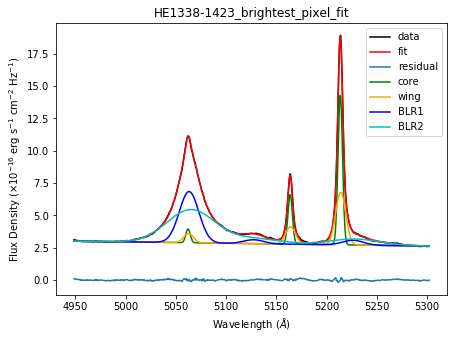

[21, 23]
4187.752940541652


In [9]:
z = {"HE1338-1423":0.04179}

objs = z.keys()

broad2= {'HE1338-1423':True}

p_init= {'HE1338-1423':[10,15,12537.0,100.0,2,1,12337.0,200.0,5.0,1.0,12537.0,500.0,0.5,0.5,12537.0,1000.0,-0.001,2.0]}

for obj in objs:
     algorithm_script(obj,p_init[obj],z[obj],broad2[obj]) 